In [1]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Données
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
t = x + y                        # Total des observations

# Hyperparamètres des lois a priori
mu_alpha, sigma_alpha = 0, 2  # Pour logit(p)
mu_delta, sigma_delta = 0, 2  # Pour logit(theta)

# Initialisation des chaînes MCMC
n_iter = 5000
alpha_chain = np.zeros(n_iter)
delta_chain = np.zeros(n_iter)
p_chain = np.zeros(n_iter)
theta_chain = np.zeros(n_iter)

# Valeurs initiales
alpha_chain[0] = np.random.normal(mu_alpha, sigma_alpha)
delta_chain[0] = np.random.normal(mu_delta, sigma_delta)

# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

# Algorithme Metropolis-Hastings
for i in range(1, n_iter):
    # Propositions
    alpha_prop = np.random.normal(alpha_chain[i-1], 0.1)
    delta_prop = np.random.normal(delta_chain[i-1], 0.1)
    
    # Transformations
    p_prop = inv_logit(alpha_prop)
    theta_prop = inv_logit(delta_prop)
    
    # Calcul de la vraisemblance
    likelihood_current = np.prod(stats.binom.pmf(y, t, inv_logit(alpha_chain[i-1])))
    likelihood_proposed = np.prod(stats.binom.pmf(y, t, p_prop))
    
    # Calcul des a priori
    prior_current = stats.norm.pdf(alpha_chain[i-1], mu_alpha, sigma_alpha) * stats.norm.pdf(delta_chain[i-1], mu_delta, sigma_delta)
    prior_proposed = stats.norm.pdf(alpha_prop, mu_alpha, sigma_alpha) * stats.norm.pdf(delta_prop, mu_delta, sigma_delta)
    
    # Ratio d'acceptation
    acceptance_ratio = (likelihood_proposed * prior_proposed) / (likelihood_current * prior_current)
    
    # Acceptation ou rejet
    if np.random.rand() < min(1, acceptance_ratio):
        alpha_chain[i] = alpha_prop
        delta_chain[i] = delta_prop
    else:
        alpha_chain[i] = alpha_chain[i-1]
        delta_chain[i] = delta_chain[i-1]
    
    p_chain[i] = inv_logit(alpha_chain[i])
    theta_chain[i] = inv_logit(delta_chain[i])

# Tracé des distributions a posteriori
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(p_chain, bins=30, density=True)
plt.title("Distribution a posteriori de p")

plt.subplot(1, 2, 2)
plt.hist(theta_chain, bins=30, density=True)
plt.title("Distribution a posteriori de θ")
plt.show()

In [2]:
# Données
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
T = x + y                        # Total des observations

In [3]:

# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))


def log_posterior_alpha(alpha, prior_mu, prior_sd, health_status, y,t,p) :
    
    
    log_prior = norm.logpdf(alpha, prior_mu, prior_sd)
    log_lik = 0.0
    for i in range(len(y)) : 
        if health_status[i] == 1 : 
            if y[i] > 0 : 
                return -np.inf
            
        else : 
            val_i = y[i]*np.log(p) + (t[i]-y[i])*np.log(1-p) 
            if np.isinf(val_i) or np.isnan(val_i):
                return -np.inf
            log_lik += val_i
        
    return log_prior + log_lik
    

def log_posterior_delta(delta, prior_mu, prior_sd, health_status,theta) :
    
    
    log_prior = norm.logpdf(delta, prior_mu, prior_sd)
    log_lik = np.sum(health_status) * np.log(theta) + np.sum(1-health_status) * np.log(1-theta)
        
    return log_prior + log_lik


In [13]:
def heart_mixture_sampler(n_iter,x,y,T) : 
    # Données
    n_individual = len(x)
    
    # Variance des noyaux de propositions
    proposal_sd_alpha = 1
    proposal_sd_delta = 1.5

    # Hyperparamètres des lois a priori
    prior_mu_alpha, prior_sd_alpha = 0, 1000  # Pour logit(p), A REVOIR COMMENT ON CHOISIT NOTRE PRIOR 
    prior_mu_delta, prior_sd_delta = 0, 1000  # Pour logit(theta)

    # Initialisation des chaînes MCMC
    alpha_chain = np.zeros(n_iter)
    delta_chain = np.zeros(n_iter)
    beta_chain = np.zeros(n_iter)
    p_chain = np.zeros(n_iter)
    theta_chain = np.zeros(n_iter)
    health_status = np.zeros(n_individual)
    
    beta_chain[0] = np.exp(alpha_chain[0])
    p_chain[0] = beta_chain[0] / (1 + beta_chain[0])
    theta_chain[0] = inv_logit(delta_chain[0])
    
    # On stocke les ratio d'accpetation 
    acceptance_ratio_alpha = np.zeros(n_iter)
    acceptance_ratio_delta = np.zeros(n_iter)
    
    # On mets à jours les paramètres
    for t in range(1,n_iter) :
        
        
        # Mise à jour des variables latentes 
        for i in range(n_individual):
            if y[i] > 0:                 # Pas possible d'être guéri
                health_status[i] = 0
            else:                        # On tire un Bernoulli
            
                numerator = theta_chain[t-1]
                denominator = theta_chain[t-1] + (1 - theta_chain[t-1])*( (1-p_chain[t-1])**T[i] )
                prob_gueri = numerator/denominator
                
                # health_status[i] = 1 si unif < prob_gueri, sinon 0
                if np.random.rand() < prob_gueri:
                    health_status[i] = 1
                else:
                    health_status[i] = 0
                    
        # Mise à jour de alpha via Metropolis-Hastings
        alpha_prop = alpha_chain[t-1] + np.random.normal(0, proposal_sd_alpha) ### A revoir comment on choisit la variance du noyau de proposition 
        p_prop = np.exp(alpha_prop) / (1 + np.exp(alpha_prop))
        
        log_post_prop_alpha = log_posterior_alpha(alpha_prop, prior_mu_alpha, prior_sd_alpha, health_status, y, T, p_prop)
        log_post_curr_alpha = log_posterior_alpha(alpha_chain[t-1], prior_mu_alpha, prior_sd_alpha, health_status, y, T, p_chain[t-1])

        acceptance_ratio = np.exp(log_post_prop_alpha - log_post_curr_alpha)
        acceptance_ratio_alpha[t] = min(1,acceptance_ratio)
        if np.random.rand() < acceptance_ratio_alpha[t]:
            alpha_chain[t] = alpha_prop
            p_chain[t] = p_prop
        else:
            alpha_chain[t] = alpha_chain[t-1]
            p_chain[t] = p_chain[t-1]   
        
        # Mise à jour de delta via Metropolis-Hastings
        delta_prop = delta_chain[t-1] + np.random.normal(0, proposal_sd_delta) ### A revoir comment on choisit la variance du noyau de proposition 
        theta_prop = inv_logit(delta_prop)
        
        log_post_prop_delta = log_posterior_delta(delta_prop, prior_mu_delta, prior_sd_delta, health_status,theta_prop)
        log_post_curr_delta = log_posterior_delta(delta_chain[t-1], prior_mu_delta, prior_sd_delta, health_status,theta_chain[t-1])
        
        acceptance_ratio = np.exp(log_post_prop_delta - log_post_curr_delta)
        acceptance_ratio_delta[t] = min(1,acceptance_ratio)
        
        if np.random.rand() < acceptance_ratio:
            delta_chain[t] = delta_prop
            theta_chain[t] = theta_prop 
        else:
            delta_chain[t] = delta_chain[t-1]
            theta_chain[t] = theta_chain[t-1]
            
        beta_chain[t] = np.exp(alpha_chain[t])
        
        
    return {
        'alpha_chain': alpha_chain, 
        'delta_chain': delta_chain, 
        'beta_chain': beta_chain, 
        'p_chain': p_chain, 
        'theta_chain': theta_chain, 
        'health_status': health_status, 
        'acceptance_ratio_alpha': acceptance_ratio_alpha,
        'acceptance_ratio_delta': acceptance_ratio_delta
    }
        
    
    


Taux d'acceptation moyen (alpha): 0.316
Taux d'acceptation moyen (delta): 0.442


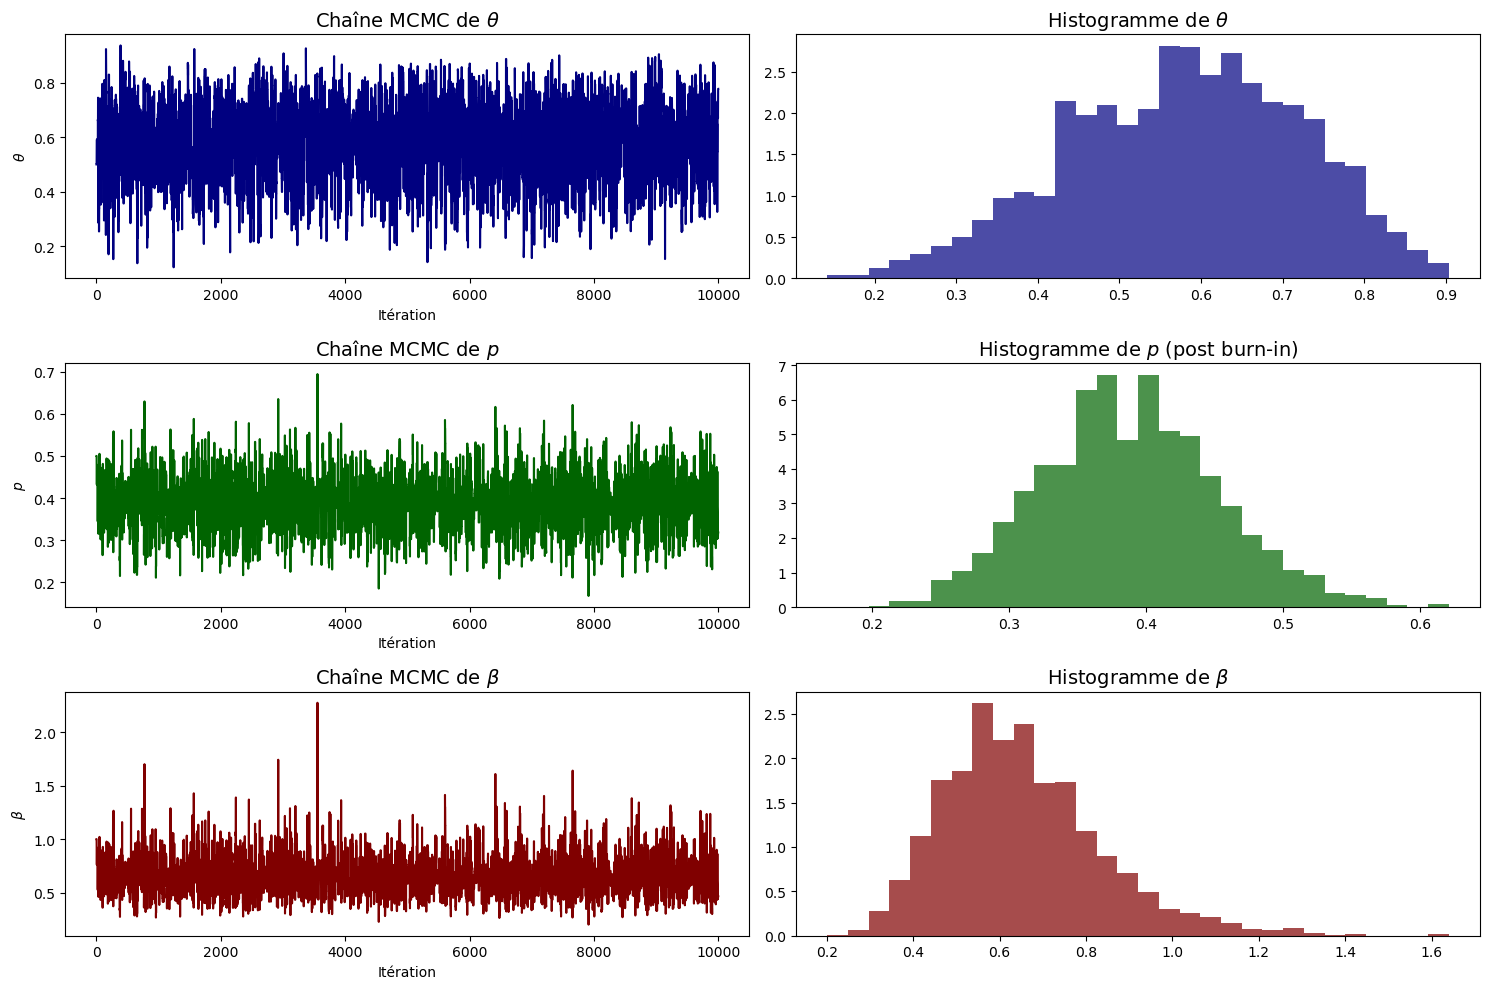

In [16]:
n_iter = 10000
results = heart_mixture_sampler(n_iter, x, y, T)


# Extraction des résultats
alpha_chain = results['alpha_chain']
delta_chain = results['delta_chain']
beta_chain = results['beta_chain']
p_chain = results['p_chain']
theta_chain = results['theta_chain']
acceptance_ratio_alpha = results['acceptance_ratio_alpha']
acceptance_ratio_delta = results['acceptance_ratio_delta']

# Affichage des résultats numériques des taux d'acceptation
print(f"Taux d'acceptation moyen (alpha): {np.mean(acceptance_ratio_alpha):.3f}")
print(f"Taux d'acceptation moyen (delta): {np.mean(acceptance_ratio_delta):.3f}")

# Visualisation des chaînes MCMC (p, theta, beta)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Chaîne de theta
axes[0,0].plot(theta_chain, color='navy')
axes[0,0].set_title(r'Chaîne MCMC de $\theta$', fontsize=14)
axes[0,0].set_xlabel('Itération')
axes[0,0].set_ylabel(r'$\theta$')

axes[0,1].hist(theta_chain[int(n_iter/2):], bins=30, density=True, color='navy', alpha=0.7)
axes[0,1].set_title(r'Histogramme de $\theta$', fontsize=14)

# Chaîne de p
axes[1,0].plot(p_chain, color='darkgreen')
axes[1,0].set_title(r'Chaîne MCMC de $p$', fontsize=14)
axes[1,0].set_xlabel('Itération')
axes[1,0].set_ylabel(r'$p$')

axes[1,1].hist(p_chain[int(n_iter/2):], bins=30, density=True, color='darkgreen', alpha=0.7)
axes[1,1].set_title(r'Histogramme de $p$ (post burn-in)', fontsize=14)

# Chaîne de beta
axes[2,0].plot(beta_chain, color='maroon')
axes[2,0].set_title(r'Chaîne MCMC de $\beta$', fontsize=14)
axes[2,0].set_xlabel('Itération')
axes[2,0].set_ylabel(r'$\beta$')

axes[2,1].hist(beta_chain[int(n_iter/2):], bins=30, density=True, color='maroon', alpha=0.7)
axes[2,1].set_title(r'Histogramme de $\beta$', fontsize=14)

plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import numpy as np

# On suppose que tu as déjà les résultats du sampler dans "results"
chains = {
    'alpha': results['alpha_chain'][1000:],  # burn-in de 1000
    'beta': results['beta_chain'][1000:], 
    'delta': results['delta_chain'][1000:], 
    'theta': results['theta_chain'][1000:]
}

summary = []
for param, chain in chains.items():
    mean = np.mean(chain)
    sd = np.std(chain)
    median = np.median(chain)
    val2_5 = np.percentile(chain, 2.5)
    val97_5 = np.percentile(chain, 97.5)
    mc_error = sd / np.sqrt(len(chain))  # erreur de Monte Carlo approximative
    summary.append([param, mean, sd, mc_error, val2_5, median, val97_5])

summary_df = pd.DataFrame(summary, columns=["param", "mean", "sd", "MC_error", "val2.5pc", "median", "val97.5pc"])
summary_df.set_index('param', inplace=True)

print(summary_df.round(4))


         mean      sd  MC_error  val2.5pc  median  val97.5pc
param                                                       
alpha -0.4620  0.2712    0.0029   -0.9862 -0.4525     0.0518
beta   0.6534  0.1776    0.0019    0.3730  0.6360     1.0532
delta  0.3251  0.6281    0.0066   -0.8728  0.3310     1.6080
theta  0.5738  0.1408    0.0015    0.2947  0.5820     0.8331
